# CLASSIFY DATA

Classify data for machine learning algorithm training.

In [1]:
%matplotlib inline

# Reading files
import h5py
import toml

# Scientific computing
import numpy as np
import pandas as pd

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#sns.set_context("paper")

# Other
import os
import subprocess
from random import choice
import time as pytime
from IPython.display import display, clear_output

# Suppress NaturalNameWarning raised by HDFStore
import warnings
import tables
warnings.filterwarnings("ignore", category=tables.NaturalNameWarning)

## Preparation
Create folders.

In [2]:
# Create 'ris' folder
if not os.path.exists("ris"):
    os.makedirs("ris")
# Create 'plot' folder
if not os.path.exists("ris/plots"):
    os.makedirs("ris/plots")

Open cleaned data file.

In [3]:
# Open cleaned data file
data = pd.HDFStore("../cleaning/ris/OUT-cleaned.h5", mode="r")

Initialize classification parameter.

In [4]:
# Parameters
INTERVAL_LENGTH = 100
OPERATING_DAY_LIST = ["091", "092", "093", "094", "095", "096", "097", "098", "099", "100", "101", "102", "103", "104", "105"]
DETECTOR_LIST = ["143-5", "143-6", "143-7"]

# Load parameters and status from a toml file
STATUS = toml.load("status.toml")

## Classification

### Define the classification function

In [5]:
def classify():
    
    # Clear previous output
    clear_output(wait=True)
    print("ACTUAL STATUS:\n", STATUS)

    # Choose random operating day and detector
    OD = choice(OPERATING_DAY_LIST)
    DET = choice(DETECTOR_LIST)
    CHOICE = "/" + OD + "/" + DET

    if len(data[CHOICE]["time_cleaned"]) % 2 == 0:
        limit_interval = 1.1 * np.median(data[CHOICE]["time_cleaned"][1::2].to_numpy() - data[CHOICE]["time_cleaned"][::2].to_numpy())
    else:
        limit_interval = 1.1 * np.median(data[CHOICE]["time_cleaned"][1::2].to_numpy() - data[CHOICE]["time_cleaned"][:-1:2].to_numpy())

    # Choose a random starting point. If the difference in time is too big, it means I'm taking the data over a "hole".
    print("\nEXTRACTING DATA FROM: OPERATING DAY " + OD + " - DETECTOR " + DET)
    print("Searching interval...")
    i = 1
    print("Attempt:", i, "\r", end="")
    begin = int((len(data[CHOICE]["time_cleaned"]) - 200) * np.random.random())
    end = begin + INTERVAL_LENGTH
    while((data[CHOICE]["time_cleaned"][end] - data[CHOICE]["time_cleaned"][begin]) > INTERVAL_LENGTH * limit_interval):
        i += 1
        print("Attempt:", i, "\r", end="")
        begin = int((len(data[CHOICE]["time_cleaned"]) - 200) * np.random.random())
        end = begin + INTERVAL_LENGTH
    print()

    # Plot
    plt.figure(1)
    plt.plot(data[CHOICE]["time_cleaned"][begin:end], data[CHOICE]["data_cleaned"][begin:end], marker='.', linestyle='dashed')
    plt.show()

    # Classify
    print("\n\nStep:", STATUS["N"])
    print("Choice: [ yes (y) | no (n) | multi (m) | beautiful glitch (yb) | beautiful no-glitch (nb) | beautiful multi (mb) ]")
    print("Type 'exit' to interrupt.")
    answer = input("Do you see a glitch?")

    # GLITCH
    # Normal
    if answer == "y":
        print("Glitch detected.")
        # Update status
        STATUS["N_GLITCH"] += 1
        STATUS["N"] += 1
        # Save data
        dataname = "GLITCH/" + str(STATUS["N_GLITCH"])
        with pd.HDFStore("ris/OUT-classified.h5") as out_file:
            out_file.put(dataname, pd.DataFrame({"time": data[CHOICE]["time_cleaned"][begin:end], "data": data[CHOICE]["data_cleaned"][begin:end],}, columns=["time", "data"]))
        with h5py.File("ris/OUT-classified.h5") as out_file:
            out_file[dataname].attrs["TITLE"] = np.string_("From: " + CHOICE)
            out_file[dataname].attrs["VERSION"] = np.string_("Date: " + pytime.asctime() + " | Script name: classification.ipynb | Script commit ID: " + subprocess.run(["git", "log", "-1", "--format=%H", "classification.ipynb"], stdout=subprocess.PIPE).stdout.decode("ASCII").rstrip())   
    # Beautiful
    elif answer == "yb":
        print("Glitch detected; saved.")
        # Update status
        STATUS["N_GLITCH"] += 1
        STATUS["N"] += 1
        # Save data
        dataname = "GLITCH/" + str(STATUS["N_GLITCH"])
        with pd.HDFStore("ris/OUT-classified.h5") as out_file:
            out_file.put(dataname, pd.DataFrame({"time": data[CHOICE]["time_cleaned"][begin:end], "data": data[CHOICE]["data_cleaned"][begin:end],}, columns=["time", "data"]))
        with h5py.File("ris/OUT-classified.h5") as out_file:
            out_file[dataname].attrs["TITLE"] = np.string_("From: " + CHOICE)
            out_file[dataname].attrs["VERSION"] = np.string_("Date: " + pytime.asctime() + " | Script name: classification.ipynb | Script commit ID: " + subprocess.run(["git", "log", "-1", "--format=%H", "classification.ipynb"], stdout=subprocess.PIPE).stdout.decode("ASCII").rstrip())   
        # Save plot
        plt.figure(2)
        plt.plot(data[CHOICE]["time_cleaned"][begin:end], data[CHOICE]["data_cleaned"][begin:end], marker='.', linestyle='dashed')
        plt.title("Glitch " + str(STATUS["N_GLITCH"]))
        plt.xlabel("Time [s]")
        plt.ylabel("Signal [T_cmb V / W]")
        plt.savefig("ris/plots/glitch-" + str(STATUS["N_GLITCH"]) + ".png", dpi=600)
        plt.close()

    # NO GLITCH
    # Normal
    elif answer == "n":
        print('No glitch detected.')
        # Update status
        STATUS["N_NO_GLITCH"] += 1
        STATUS["N"] += 1
        # Save data
        dataname = "NO_GLITCH/" + str(STATUS["N_NO_GLITCH"])
        with pd.HDFStore("ris/OUT-classified.h5") as out_file:
            out_file.put(dataname, pd.DataFrame({"time": data[CHOICE]["time_cleaned"][begin:end], "data": data[CHOICE]["data_cleaned"][begin:end],}, columns=["time", "data"]))
        with h5py.File("ris/OUT-classified.h5") as out_file:
            out_file[dataname].attrs["TITLE"] = np.string_("From: " + CHOICE)
            out_file[dataname].attrs["VERSION"] = np.string_("Date: " + pytime.asctime() + " | Script name: classification.ipynb | Script commit ID: " + subprocess.run(["git", "log", "-1", "--format=%H", "classification.ipynb"], stdout=subprocess.PIPE).stdout.decode("ASCII").rstrip())   
    # Beautiful
    elif answer == "nb":
        print("No glitch detected; saved.")
        # Update status
        STATUS["N_NO_GLITCH"] += 1
        STATUS["N"] += 1
        # Save data
        dataname = "NO_GLITCH/" + str(STATUS["N_NO_GLITCH"])
        with pd.HDFStore("ris/OUT-classified.h5") as out_file:
            out_file.put(dataname, pd.DataFrame({"time": data[CHOICE]["time_cleaned"][begin:end], "data": data[CHOICE]["data_cleaned"][begin:end],}, columns=["time", "data"]))
        with h5py.File("ris/OUT-classified.h5") as out_file:
            out_file[dataname].attrs["TITLE"] = np.string_("From: " + CHOICE)
            out_file[dataname].attrs["VERSION"] = np.string_("Date: " + pytime.asctime() + " | Script name: classification.ipynb | Script commit ID: " + subprocess.run(["git", "log", "-1", "--format=%H", "classification.ipynb"], stdout=subprocess.PIPE).stdout.decode("ASCII").rstrip())   
        # Save plot
        plt.figure(2)
        plt.plot(data[CHOICE]["time_cleaned"][begin:end], data[CHOICE]["data_cleaned"][begin:end], marker='.', linestyle='dashed')
        plt.title("No glitch " + str(STATUS["N_NO_GLITCH"]))
        plt.xlabel("Time [s]")
        plt.ylabel("Signal [T_cmb V / W]")
        plt.savefig("ris/plots/no_glitch-" + str(STATUS["N_NO_GLITCH"]) + ".png", dpi=600)
        plt.close()

    # MULTI GLITCH
    # Normal
    elif answer == "m":
        print("Multi glitch detected.")
        # Update status
        STATUS["N_MULTI"] += 1
        STATUS["N"] += 1
        # Save data
        dataname = "MULTI_GLITCH/" + str(STATUS["N_MULTI"])
        with pd.HDFStore("ris/OUT-classified.h5") as out_file:
            out_file.put(dataname, pd.DataFrame({"time": data[CHOICE]["time_cleaned"][begin:end], "data": data[CHOICE]["data_cleaned"][begin:end],}, columns=["time", "data"]))
        with h5py.File("ris/OUT-classified.h5") as out_file:
            out_file[dataname].attrs["TITLE"] = np.string_("From: " + CHOICE)
            out_file[dataname].attrs["VERSION"] = np.string_("Date: " + pytime.asctime() + " | Script name: classification.ipynb | Script commit ID: " + subprocess.run(["git", "log", "-1", "--format=%H", "classification.ipynb"], stdout=subprocess.PIPE).stdout.decode("ASCII").rstrip())   
    # Beautiful
    elif answer == "mb":
        print('Multi glitch detected; saved.')
        # Update status
        STATUS["N_MULTI"] += 1
        STATUS["N"] += 1
        # Save data
        dataname = "MULTI_GLITCH/" + str(STATUS["N_MULTI"])
        with pd.HDFStore("ris/OUT-classified.h5") as out_file:
            out_file.put(dataname, pd.DataFrame({"time": data[CHOICE]["time_cleaned"][begin:end], "data": data[CHOICE]["data_cleaned"][begin:end],}, columns=["time", "data"]))
        with h5py.File("ris/OUT-classified.h5") as out_file:
            out_file[dataname].attrs["TITLE"] = np.string_("From: " + CHOICE)
            out_file[dataname].attrs["VERSION"] = np.string_("Date: " + pytime.asctime() + " | Script name: classification.ipynb | Script commit ID: " + subprocess.run(["git", "log", "-1", "--format=%H", "classification.ipynb"], stdout=subprocess.PIPE).stdout.decode("ASCII").rstrip())   
        # Save plot
        plt.figure(2)
        plt.plot(data[CHOICE]["time_cleaned"][begin:end], data[CHOICE]["data_cleaned"][begin:end], marker='.', linestyle='dashed')
        plt.title("Multi glitch " + str(STATUS["N_MULTI"]))
        plt.xlabel("Time [s]")
        plt.ylabel("Signal [T_cmb V / W]")
        plt.savefig("ris/plots/multi_glitch-" + str(STATUS["N_MULTI"]) + ".png", dpi=600)
        plt.close()

    elif answer == "exit":
        return answer
    
    else:
        print('Unable to classify.')

    # Save parameters
    with open("status.toml", mode="w") as toml_status_file:
        toml.dump(STATUS, toml_status_file)

### Classify

Now run this function how many times you want.

ACTUAL STATUS:
 {'N': 18, 'N_GLITCH': 8, 'N_MULTI': 1, 'N_NO_GLITCH': 9}

EXTRACTING DATA FROM: OPERATING DAY 100 - DETECTOR 143-6
Searching interval...
Attempt: 1 


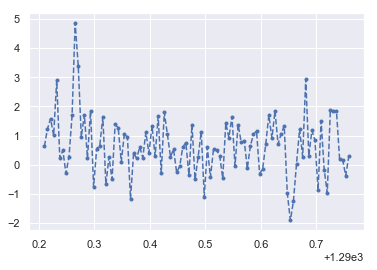



Step: 18
Choice: [ yes (y) | no (n) | multi (m) | beautiful glitch (yb) | beautiful no-glitch (nb) | beautiful multi (mb) ]
Type 'exit' to interrupt.


Do you see a glitch? exit


In [6]:
while classify() != "exit":
    pass

### Terminate the classification

In [7]:
# Close data file
data.close()

# Print "OUT-classified.h5" informations
with pd.HDFStore("ris/OUT-classified.h5") as out_file:
    print(out_file.info())

<class 'pandas.io.pytables.HDFStore'>
File path: ris/OUT-classified.h5
/GLITCH/1                  frame        (shape->[100,2])
/GLITCH/2                  frame        (shape->[100,2])
/GLITCH/3                  frame        (shape->[100,2])
/GLITCH/4                  frame        (shape->[100,2])
/GLITCH/5                  frame        (shape->[100,2])
/GLITCH/6                  frame        (shape->[100,2])
/GLITCH/7                  frame        (shape->[100,2])
/GLITCH/8                  frame        (shape->[100,2])
/MULTI_GLITCH/1            frame        (shape->[100,2])
/NO_GLITCH/1               frame        (shape->[100,2])
/NO_GLITCH/2               frame        (shape->[100,2])
/NO_GLITCH/3               frame        (shape->[100,2])
/NO_GLITCH/4               frame        (shape->[100,2])
/NO_GLITCH/5               frame        (shape->[100,2])
/NO_GLITCH/6               frame        (shape->[100,2])
/NO_GLITCH/7               frame        (shape->[100,2])
/NO_GLITCH/8     

### Reset the classification